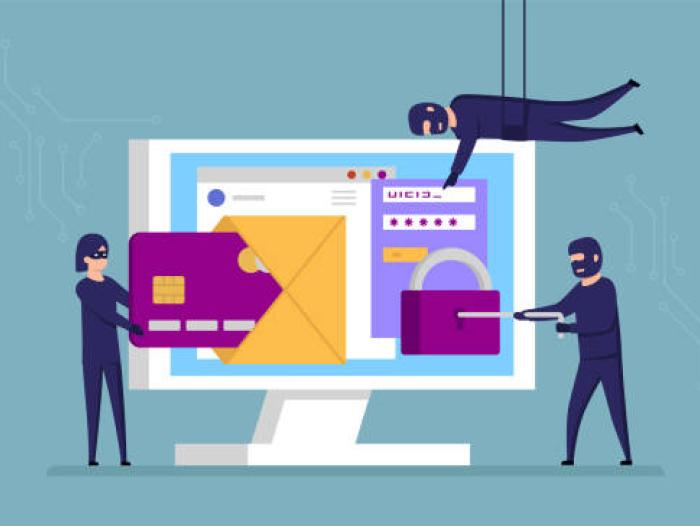

# Detecção de fraude em cartões de crédito.

## Definição do problema.

A detecção de fraudes de cartão de crédito é extremamente importante, pois tem como objetivo identificar e prevenir transações fraudulentas, proporcionando proteção tanto para as instituições financeiras quanto para os titulares dos cartões.

As fraudes de cartão de crédito representam um impacto financeiro significativo para os bancos e podem causar sérios prejuízos aos clientes, além de afetar a confiança no sistema financeiro como um todo. De acordo com um relatório recente da [IBM](https://www.ibm.com/blogs/ibm-comunica/estudo-de-fraude/)(agosto de 2022), diferentes regiões do mundo e gerações têm diferentes frequências e impactos de fraudes financeiras, bem como atitudes das vítimas em relação à detecção dessas fraudes e às instituições responsáveis por protegê-las de indivíduos mal-intencionados.

O Relatório Global de Impacto de Fraude Financeira da IBM em 2022 também revelou que, à medida que os consumidores globais migraram quase que exclusivamente para cartões de crédito e pagamentos digitais, os cidadãos dos EUA foram vítimas com maior frequência do que todos os outros países pesquisados no relatório. Isso resultou em um custo médio de US$ 265 por ano para os consumidores americanos em cobranças financeiras fraudulentas feitas por terceiros não autorizados.

A detecção eficiente de fraudes permite a identificação precoce de atividades suspeitas, evitando perdas financeiras e protegendo os dados sensíveis dos clientes. Além disso, a detecção de fraudes contribui para manter a integridade e a segurança do mercado de cartões de crédito, promovendo a sustentabilidade e a confiança nas transações eletrônicas.

## Coleta de dados.

In [1]:
#Importando pacotes e bibliotecas.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#classificadores
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

#outras bibliotecas
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, ShuffleSplit, learning_curve, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import roc_curve, accuracy_score, classification_report, confusion_matrix, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

O conjunto de dados escolhido para este estudo contém transações realizadas por cartões de crédito em setembro de 2013 por portadores de cartões europeus e apresenta transações que ocorreram em dois dias, onde temos 492 fraudes em um total de 284.807 transações. O conjunto de dados é altamente desbalanceado, a classe positiva (fraudes) representa 0,172% de todas as transações.

Ele contém apenas variáveis de entrada numéricas que são o resultado de uma transformação PCA. Infelizmente, devido a questões de confidencialidade LGPD, as características originais e mais informações de fundo sobre os dados não foram fornecidas. As características V1, V2, ... V28 são os componentes principais obtidos com o PCA, as únicas características que não foram transformadas com o PCA são 'Time' (Tempo) e 'Amount' (Valor). A característica 'Time' contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados. A característica 'Amount' é o valor da transação. A característica 'Class' é a variável de resposta e assume o valor 1 em caso de fraude e 0 caso contrário.

Os dados estão disponiveis no [kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [2]:
#carregando os dados
df = pd.read_csv('creditcard.csv')

# Limpeza dos dados

In [3]:
df.shape

(284807, 31)

In [4]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
#Verificando as colunas, o formato dos dados e se há valores nulos.
#Este é um dataset pré processado via PCA conforme enunciado.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# EDA

In [7]:
print('Transações não fraudulentas: ',
      round(df['Class'].value_counts()[0] / len(df) * 100, 2), '% dos dados')
print('Transações fraudulentas: ',
      round(df['Class'].value_counts()[1] / len(df) * 100, 2), '% dos dados')

Transações não fraudulentas:  99.83 % dos dados
Transações fraudulentas:  0.17 % dos dados


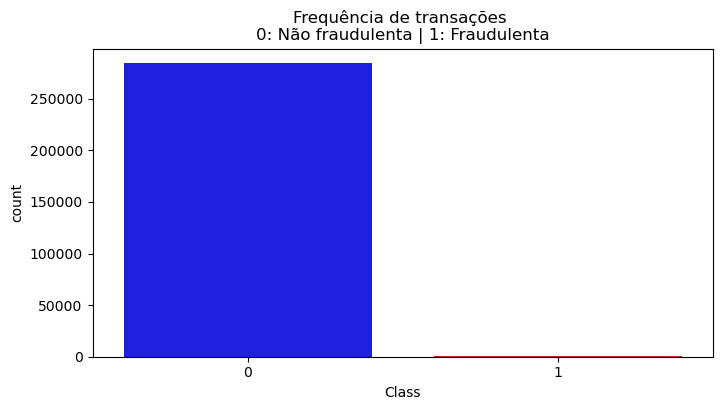

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Class', palette=['b', 'r'])
plt.title('Frequência de transações \n0: Não fraudulenta | 1: Fraudulenta')
plt.show()

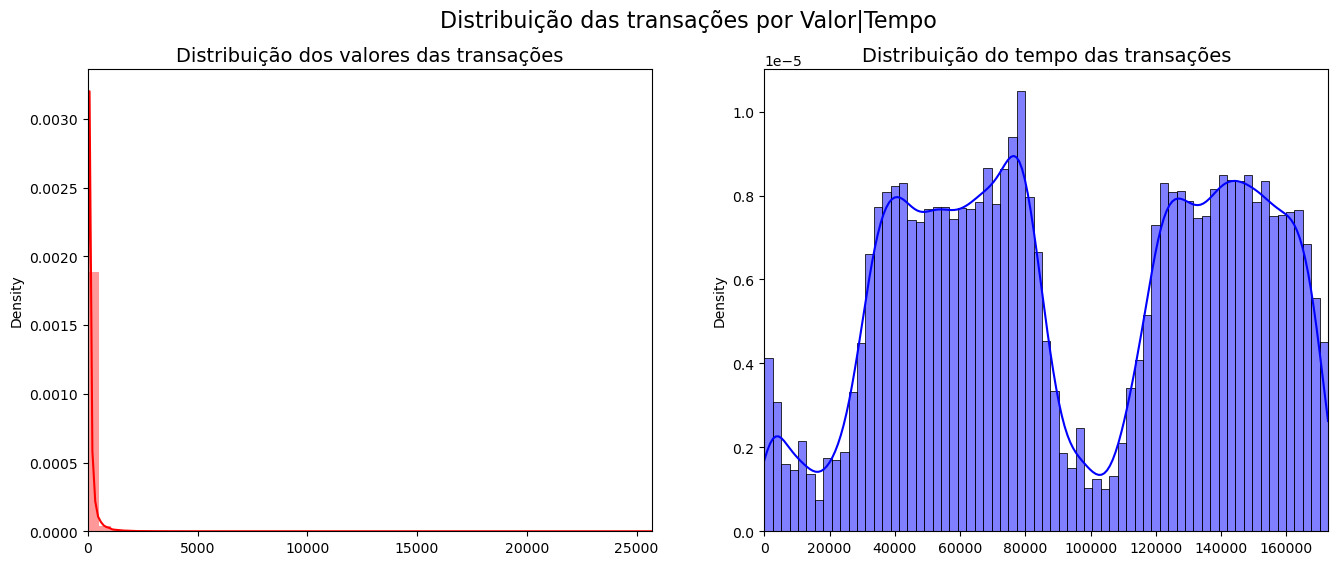

In [9]:
import warnings

# Ignorar o UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

#Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribuição dos valores das transações', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.histplot(time_val, ax=ax[1], color='b', kde=True, stat="density")
ax[1].set_title('Distribuição do tempo das transações', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.suptitle('Distribuição das transações por Valor|Tempo', fontsize=16)
plt.show()

Podemos observar que o valor das nossas transações não é muito elevado e que elas apresentam uma maior concentração em dois períodos distintos. É importante lembrar que nossa base de dados foi coletada ao longo de dois dias, sendo que os picos na distribuição temporal nos levam a crer que correspondem ao período diurno e às mínimas, aos períodos noturnos.

## Seleção de recursos e preparo.

#### Desbalanceamento.

Nosso banco de dados está extremamente desbalanceado (uma base de dados é considerada desbalanceada quando a distribuição das classes alvo é significativamente desproporcional, com uma classe sendo muito mais frequente do que a outra; no nosso caso, transações não fraudulentas representam 99,83% dos dados). Isso precisa ser tratado para evitar diversos problemas e erros de análise, tais como:

1. Viés nos resultados: Em uma base de dados desbalanceada, o modelo de aprendizado de máquina tende a favorecer a classe mais frequente durante o treinamento. Isso pode levar a resultados enviesados e imprecisos, com uma capacidade limitada de identificar corretamente a classe minoritária. O tratamento adequado dos dados desbalanceados ajuda a evitar esse viés e melhora a precisão do modelo em ambas as classes.

2. Desempenho do modelo: Modelos de aprendizado de máquina geralmente funcionam melhor quando há uma distribuição equilibrada das classes na base de dados. Ao tratar uma base de dados desbalanceada, é possível melhorar o desempenho geral do modelo, aumentando sua capacidade de generalização e tornando-o mais capaz de lidar com dados de diferentes classes.

3. Detecção de eventos raros: Em alguns cenários, a classe minoritária pode representar eventos raros, como fraudes ou anomalias. Esses eventos podem ser de grande importância e interesse, mas podem ser facilmente negligenciados em uma base de dados desbalanceada. O tratamento adequado permite que o modelo detecte com mais eficácia esses eventos raros e tome medidas adequadas.

#### Escala e distribuição.

Outro ponto que devemos observar é que as colunas "Time" e "Amount" não foram tratadas, ao contrário das demais colunas. Como mencionado anteriormente neste estudo, as outras colunas foram tratadas usando o método PCA, que é uma técnica que ajuda a reduzir a dimensionalidade dos dados, identificando as direções de maior variação e permitindo a representação dos dados de forma mais simples e informativa.

#### Resumo.

1. Criaremos duas novas colunas com as informações de tempo e valores em uma escala adequada.

2. Existem 492 casos de fraude em nosso conjunto de dados, então podemos selecionar aleatoriamente 492 casos de não fraude para criar nosso novo subconjunto de dados.

3. Concatenamos os 492 casos de fraude e não fraude, criando uma nova subamostra.

Nosso objetivo é evitar o overfitting e correlações incorretas.

In [10]:
# Reescala a distribuição para ficar com média 0 e desvio-padrão 1
std_scaler = StandardScaler()
# Utiliza o IQR (Inter Quartile Range) no escalonamento
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(
    -1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [11]:
# Armazena os dados das colunas criadas anteriormente
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# Deleta as colunas criadas
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)

# Insere os valores das colunas criadas na 1ª e 2ª colunas do dataframe, respectivamente
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [12]:
# Variaveis explicativas.
X = df.drop('Class', axis=1)
# Resposta.
y = df['Class']

# Separa os dados de maneira estratificada (mantendo as proporções originais)
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):

    # Armazena os dados originais
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    # Transforma em array
    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values

    # Verifica se as distribuições de treino e teste são similares
    train_unique_label, train_counts_label = np.unique(original_ytrain,
                                                       return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest,
                                                     return_counts=True)

    print('Distribuições:')
    print(train_counts_label / len(original_ytrain))
    print(test_counts_label / len(original_ytest))
    print('-' * 100)

Distribuições:
[0.99827514 0.00172486]
[0.998262 0.001738]
----------------------------------------------------------------------------------------------------
Distribuições:
[0.99827514 0.00172486]
[0.998262 0.001738]
----------------------------------------------------------------------------------------------------
Distribuições:
[0.99827076 0.00172924]
[0.99827952 0.00172048]
----------------------------------------------------------------------------------------------------
Distribuições:
[0.99827076 0.00172924]
[0.99827952 0.00172048]
----------------------------------------------------------------------------------------------------
Distribuições:
[0.99827076 0.00172924]
[0.99827952 0.00172048]
----------------------------------------------------------------------------------------------------


In [13]:
##Criando um novo dataframe com undersampling

# Pegar uma amostra aleatória. frac = 1 significa que a fração conterá todos os dados
df = df.sample(frac=1)

# Transações fraudulentas
fraud_df = df.loc[df['Class'] == 1]
# Transações não fraudulentas (a amostra terá tamanho de 492)
non_fraud_df = df.loc[df['Class'] == 0][:492]

# concatenando os dataframes anteriores. Novamente, a fração conterá todos os dados.
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# novo dataframe com a amostra aleatória dos dataframes anteriores.
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
230801,-0.257388,0.726031,0.056911,0.867854,0.231724,-0.620791,0.475578,-1.037316,1.015486,-0.200220,...,-0.032370,-0.270019,-0.596024,0.051259,-0.116552,-0.468645,0.147331,0.247173,0.095926,0
10498,-0.252498,-0.792561,-0.469327,1.111453,2.041003,1.731595,0.135147,-0.093625,0.266155,0.082988,...,-0.358709,0.159387,0.592670,-0.053596,0.320748,-0.369121,-0.136605,-0.100845,0.039347,1
183651,0.656746,0.484052,2.045001,-1.079211,-0.479383,-0.727769,-1.178570,-0.742886,-0.852360,-0.206511,...,0.138657,0.374423,1.098574,0.080885,0.054634,-0.153073,-0.094067,0.009454,-0.036406,0
80760,1.284427,-0.306042,-0.451383,2.225147,-4.953050,4.342228,-3.656190,-0.020121,-5.407554,-0.748436,...,0.724381,-0.575924,0.495889,1.154128,-0.016186,-2.079928,-0.554377,0.455179,0.001321,1
247995,0.410396,0.811440,1.146259,1.403458,-4.159148,2.660107,-0.323217,-1.836071,-1.623740,0.259562,...,0.284831,0.564450,0.445744,-0.141136,-0.265517,0.362260,-0.416062,0.507370,0.243744,1


### Verificando as porporções do nosso novo dataframe.

Distruição das classes no novo dataset
0    0.5
1    0.5
Name: Class, dtype: float64


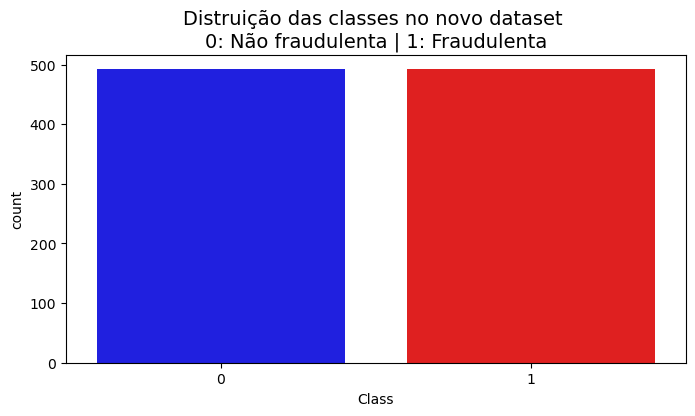

In [14]:
print('Distruição das classes no novo dataset')
print(new_df['Class'].value_counts() / len(new_df))

# Distruição das classes no dataframe balanceado
plt.figure(figsize=(8, 4))
sns.countplot(data=new_df, x='Class', palette=['b', 'r'])
plt.title(
    'Distruição das classes no novo dataset \n0: Não fraudulenta | 1: Fraudulenta',
    fontsize=14)

plt.show()

### Correlações.

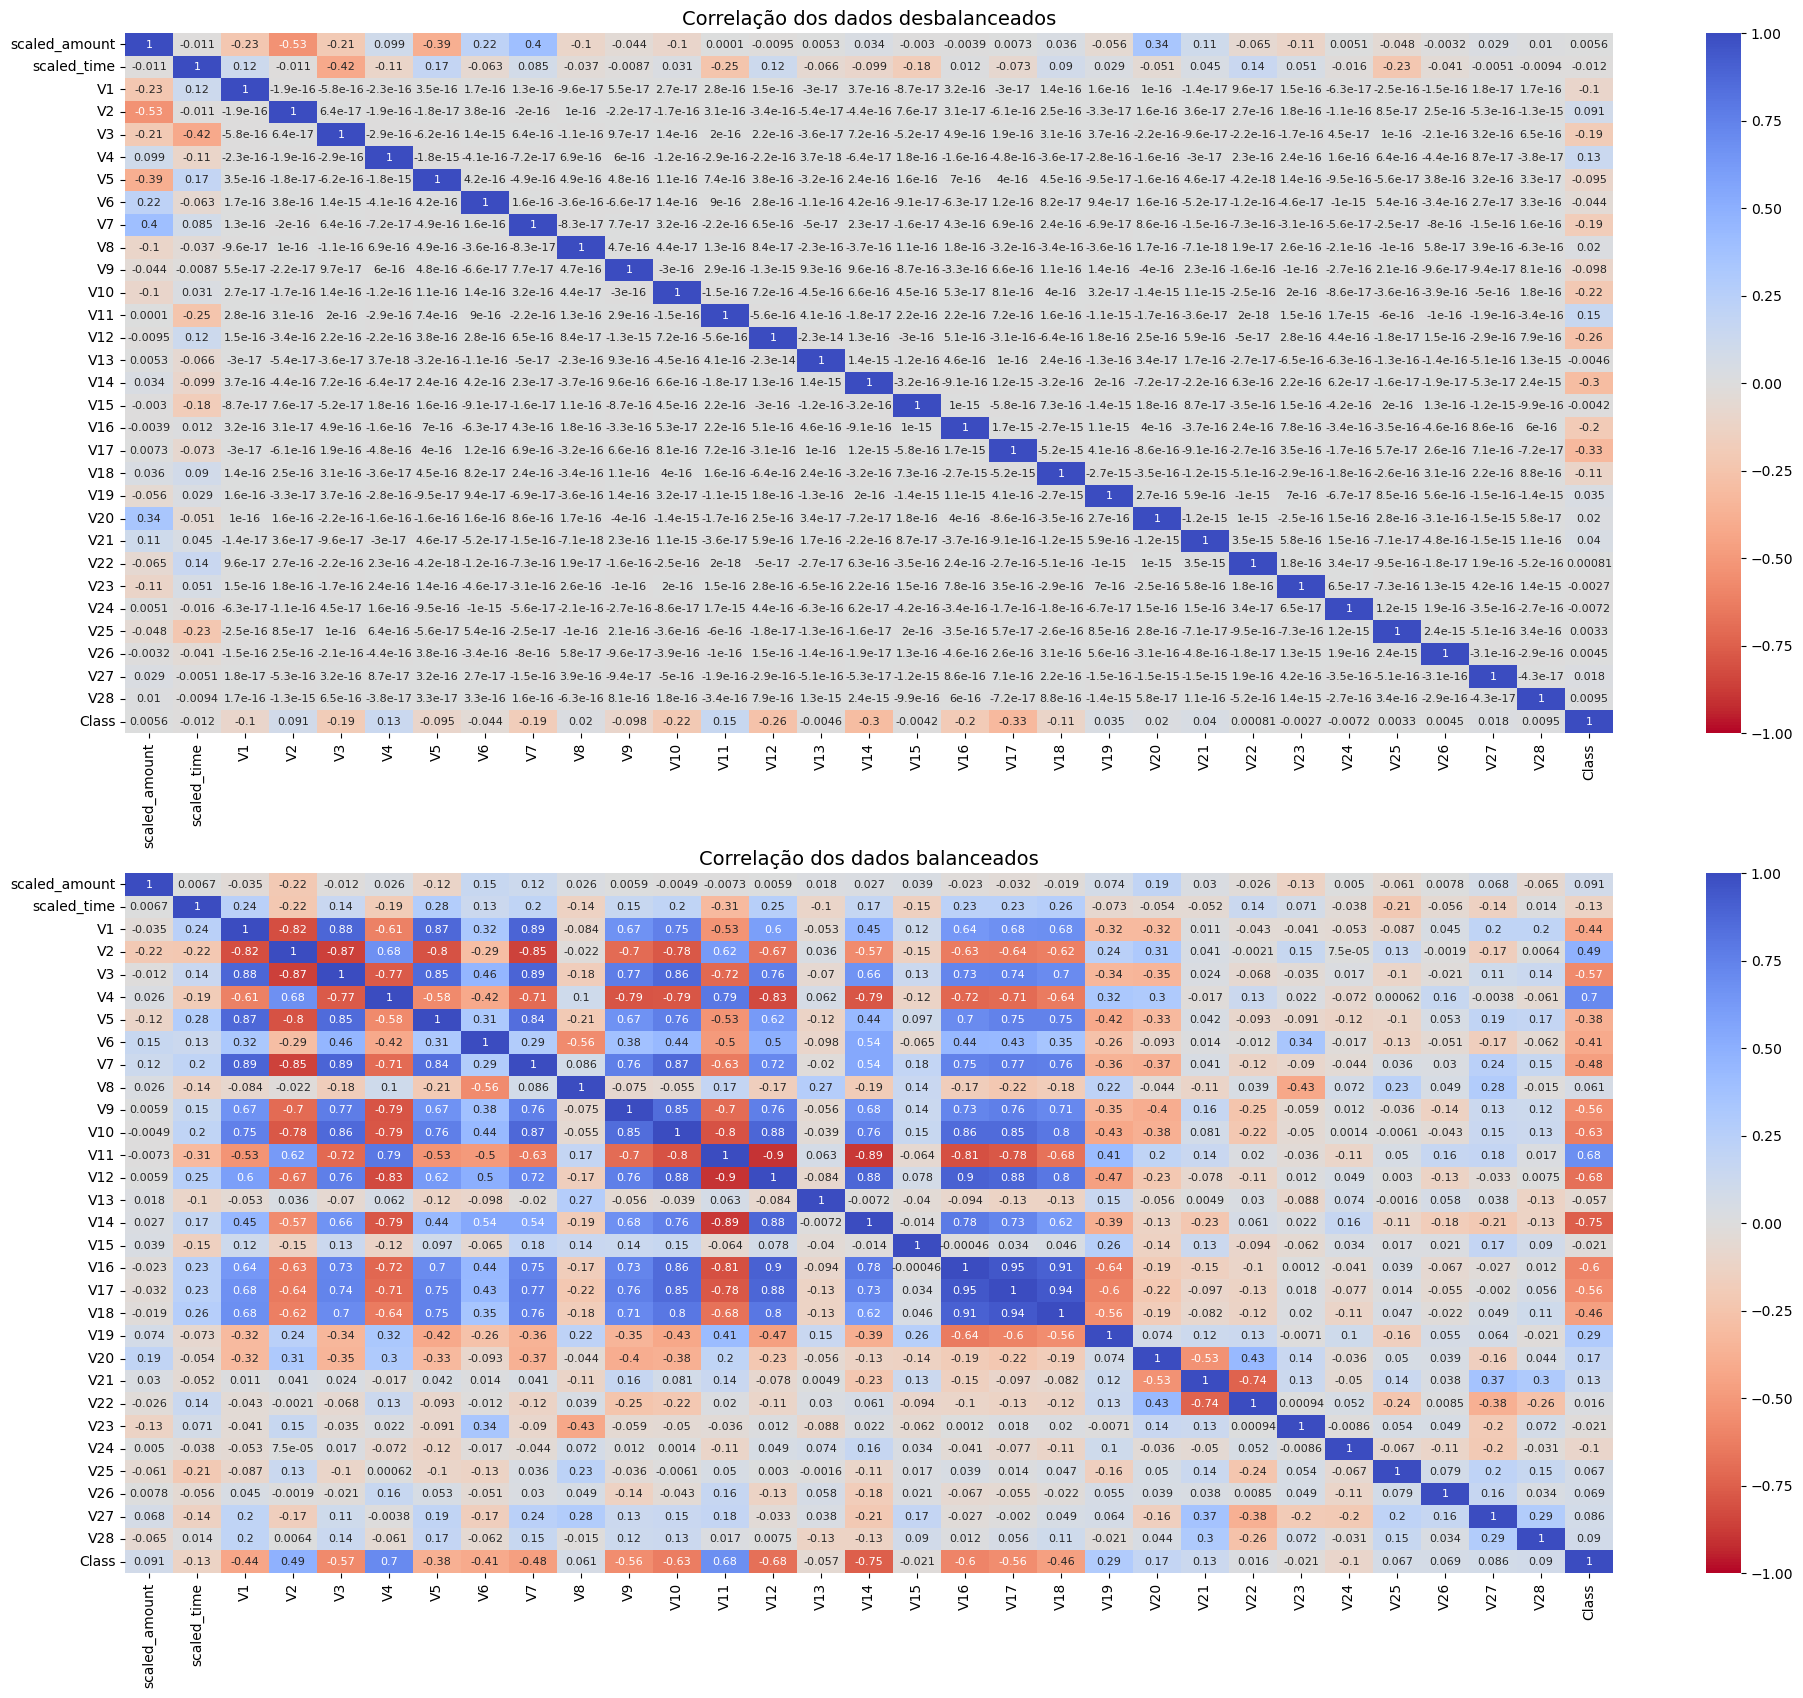

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

# Correlação do dataframe original
corr = df.corr()
sns.heatmap(corr,
            cmap='coolwarm_r',
            vmin=-1,
            vmax=1,
            annot=True,
            annot_kws={'size': 8},
            ax=ax1)
ax1.set_title('Correlação dos dados desbalanceados', fontsize=14)

# Correlação do dataframe balanceado
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr,
            cmap='coolwarm_r',
            annot=True,
            vmin=-1,
            vmax=1,
            annot_kws={'size': 8},
            ax=ax2)
ax2.set_title('Correlação dos dados balanceados', fontsize=14)

plt.show()

Por questões de privacidade da instituição que compartilhou os dados, as variáveis explicativas foram renomeadas e classificadas por ordem de importância.

A matriz de correlação no dataframe com os dados balanceados oferece uma visão mais clara das correlações entre as variáveis.

Identificamos as variáveis com as correlações mais fortes:

- Correlação negativa: V16, V14, V12 e V10. Isso indica que quanto menor seus valores, maior é a probabilidade da transação ser fraudulenta.
- Correlação positiva: V2, V4 e V11. Isso indica que quanto maiores seus valores, maior é a probabilidade da transação ser fraudulenta.

Após identificar as variaveis com correlação mais fortes podemos realizar uma análise mais detalhada dessas variáveis e verificar suas distribuições em relação à nossa variável resposta.

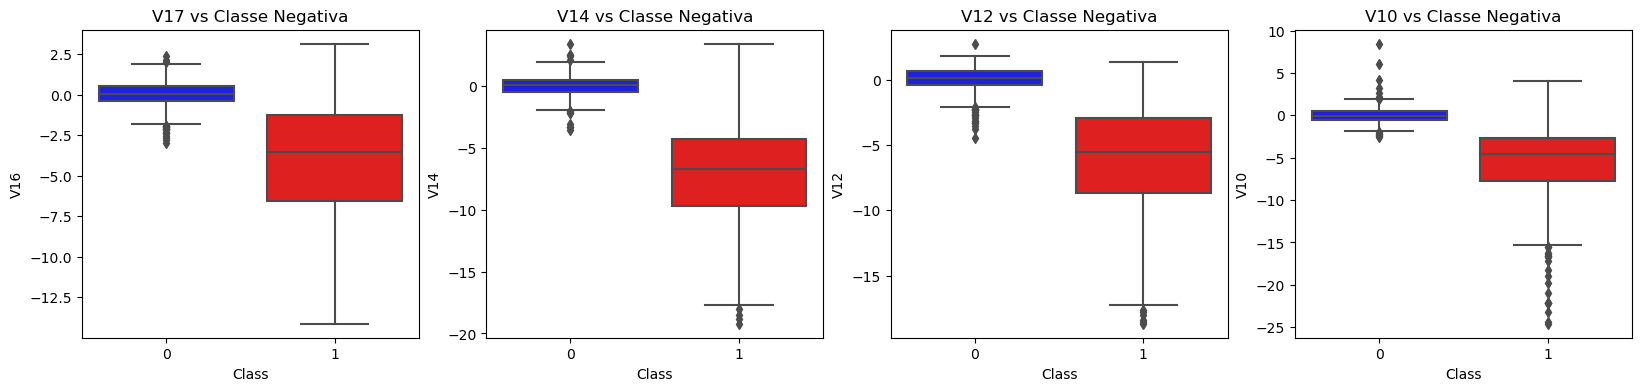

In [16]:
f, axes = plt.subplots(ncols=4, figsize=(20, 4))
colors = ['b', 'r']

sns.boxplot(x="Class", y="V16", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Classe Negativa')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Classe Negativa')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Classe Negativa')

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Classe Negativa')

plt.show()

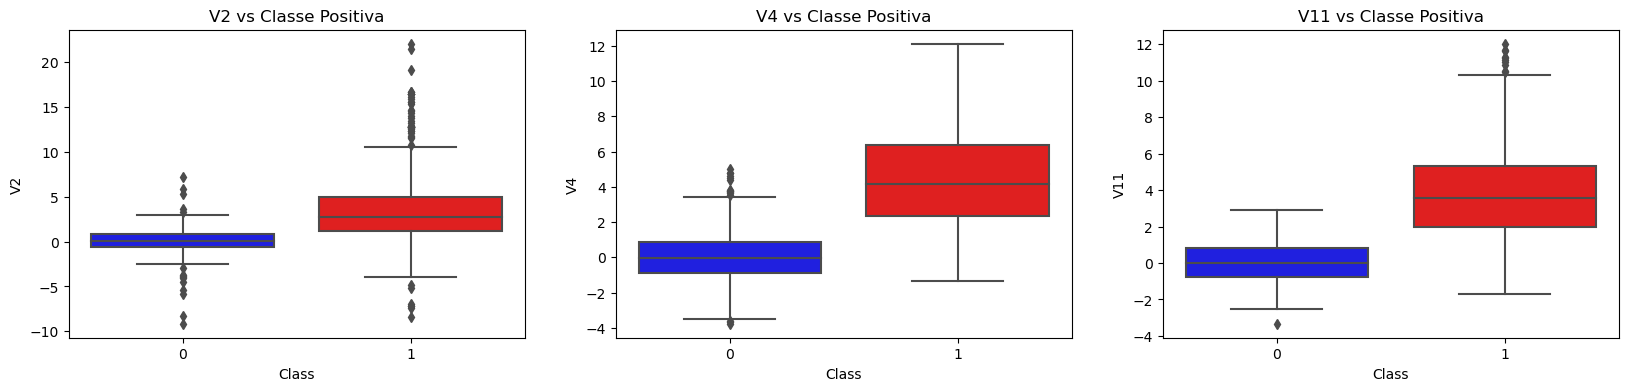

In [17]:
f, axes = plt.subplots(ncols=3, figsize=(20, 4))
colors = ['b', 'r']

sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V2 vs Classe Positiva')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Classe Positiva')

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V11 vs Classe Positiva')

plt.show()

### Remoção de outliers

O principal objetivo desta seção é remover outliers extremos das variaveis que apresentam alta correlação com a classe.

Utilizaremos o método do Intervalo Interquartil (IQR - Interquartile Range):
O IQR é calculado pela diferença entre o 75º percentil e o 25º percentil. Com base nesse valor, podemos estabelecer um limiar entre o 75º e o 25º percentil, e qualquer instância que esteja além desse limiar será removida.

É importante considerar o tradeoff na remoção de outliers. Devemos ter cuidado ao definir o limiar, multiplicando um número (por exemplo, 1.5) pelo IQR. Quanto maior o limiar, menos outliers serão detectados (por exemplo, se usarmos o número 3 na multiplicação), e quanto menor o limiar, mais outliers serão detectados. O ideal é focarmos apenas nos outliers extremos, a fim de minimizar a perda de informações e garantir uma maior acurácia do modelo.

Os passos para realizar essa remoção são os seguintes:
1. Primeiro, visualizaremos as distribuições de algumas variaveis que utilizaremos para eliminar os outliers.
2. Em seguida, determinaremos o limiar que será utilizado, ou seja, decidiremos qual número multiplicaremos pelo IQR.
   Limite Inferior: q25 - limiar
   Limite Superior: q75 + limiar
3. Por último, criaremos a condição para exclusão, em que as instâncias que excederem os limites estabelecidos serão removidas.

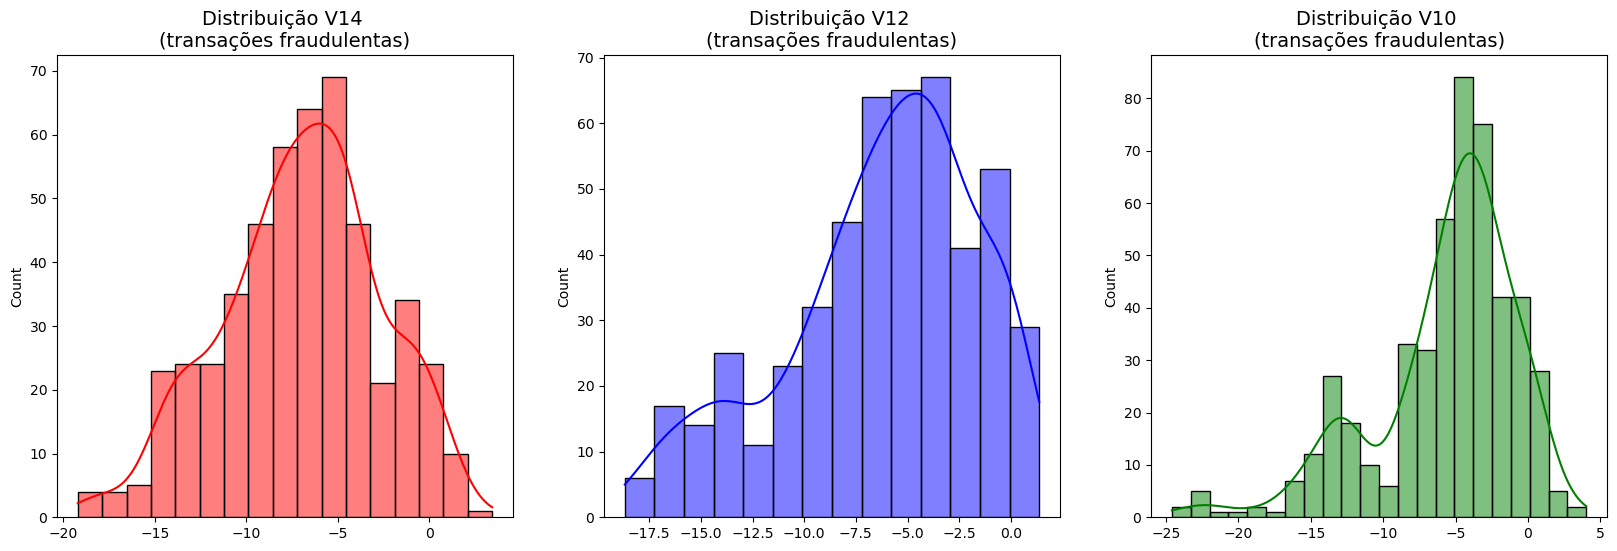

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.histplot(v14_fraud_dist, ax=ax1, color='r', kde=True)
ax1.set_title('Distribuição V14 \n(transações fraudulentas)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.histplot(v12_fraud_dist, ax=ax2, color='b', kde=True)
ax2.set_title('Distribuição V12 \n(transações fraudulentas)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.histplot(v10_fraud_dist, ax=ax3, color='g', kde=True)
ax3.set_title('Distribuição V10 \n(transações fraudulentas)', fontsize=14)

plt.show()

In [19]:
# Remover os outliers de V14 (correlação negativa alta com a classe)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
# Valores do quartil 25 e quartil 75
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('QUARTIL 25: {} | QUARTIL 75: {}'.format(q25, q75))
# Interquartile range
v14_iqr = q75 - q25
print('IQR: ', v14_iqr)

# Limiar
v14_cut_off = v14_iqr * 1.5
# Limite superior e inferior
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('LIMIAR: ', v14_cut_off)
print('V14 LIMITE INFERIOR', v14_lower)
print('V14 LIMITE SUPERIOR', v14_upper)

# Ouliers (fora os limites estabelecidos anteriormente)
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('V14 QUANTIDADE DE OUTLIERS EM FRAUDES:', len(outliers))

# Novo dataframe sem os outliers
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) |
                            (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# Remover os outliers de V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 LIMITE INFERIOR: {}'.format(v12_lower))
print('V12 LIMITE SUPERIOR: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]

print('V12 OUTLIERS: {}'.format(outliers))
print('V12 QUANTIDADE DE OUTLIERS EM FRAUDES: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) |
                            (new_df['V12'] < v12_lower)].index)
print('NÚMERO DE INSTÂNCIAS APÓS A REMOÇÃO DOS OUTLIERS: {}'.format(
    len(new_df)))
print('----' * 44)

# Remover os outliers de V10

v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 LIMITE INFERIOR: {}'.format(v10_lower))
print('V10 SUPERIOR: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]

print('V10 OUTLIERS: {}'.format(outliers))
print('V10 QUANTIDAADE DE OUTLIERS EM FRAUDES: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) |
                            (new_df['V10'] < v10_lower)].index)

print('---' * 42)
print('NÚMERO DE INSTÂNCIAS APÓS A REMOÇÃO DOS OUTLIERS: {}'.format(
    len(new_df)))

QUARTIL 25: -9.692722964972386 | QUARTIL 75: -4.282820849486865
IQR:  5.409902115485521
LIMIAR:  8.114853173228282
V14 LIMITE INFERIOR -17.807576138200666
V14 LIMITE SUPERIOR 3.8320323237414167
V14 QUANTIDADE DE OUTLIERS EM FRAUDES: 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 LIMITE INFERIOR: -17.3430371579634
V12 LIMITE SUPERIOR: 5.776973384895937
V12 OUTLIERS: [-18.5536970096458, -18.0475965708216, -18.4311310279993, -18.6837146333443]
V12 QUANTIDADE DE OUTLIERS EM FRAUDES: 4
NÚMERO DE INSTÂNCIAS APÓS A REMOÇÃO DOS OUTLIERS: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 LIMITE INFERIOR: -14.89885463232024
V10 SUPERIOR: 4.92033495834214
V10 OUTLIERS: [-15.1237521803455, -22.1870885620007, -15.2399619587112, -16.

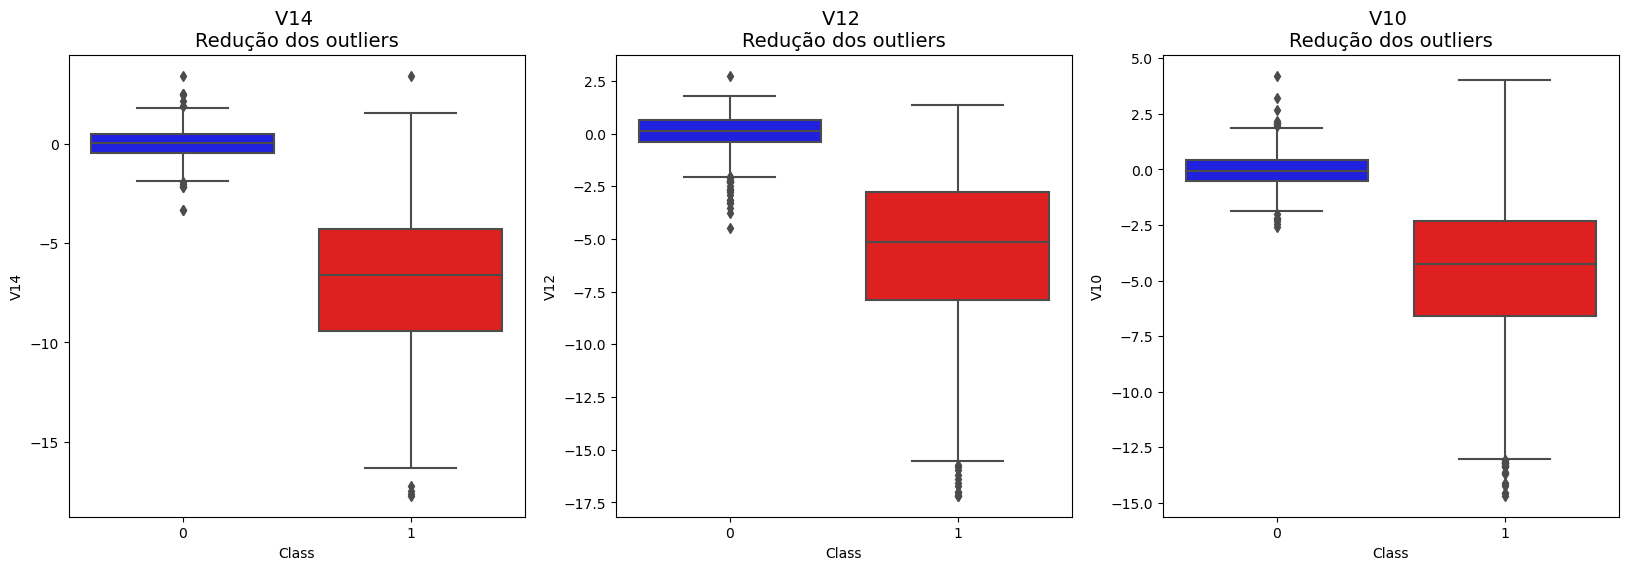

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

colors = ['b', 'r']

# V14
sns.boxplot(x='Class', y='V14', data=new_df, ax=ax1, palette=colors)
ax1.set_title('V14 \nRedução dos outliers', fontsize=14)

# V12
sns.boxplot(x='Class', y='V12', data=new_df, ax=ax2, palette=colors)
ax2.set_title('V12 \nRedução dos outliers', fontsize=14)

# V10
sns.boxplot(x='Class', y='V10', data=new_df, ax=ax3, palette=colors)
ax3.set_title('V10 \nRedução dos outliers', fontsize=14)

plt.show()

# Treino do modelo

A seguir, vamos treinar alguns modelos com diferentes tipos de classificadores e verificar qual deles é mais efetivo para determinar quais transações são fraudulentas.

In [21]:
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
230801,-0.257388,0.726031,0.056911,0.867854,0.231724,-0.620791,0.475578,-1.037316,1.015486,-0.200220,...,-0.032370,-0.270019,-0.596024,0.051259,-0.116552,-0.468645,0.147331,0.247173,0.095926,0
10498,-0.252498,-0.792561,-0.469327,1.111453,2.041003,1.731595,0.135147,-0.093625,0.266155,0.082988,...,-0.358709,0.159387,0.592670,-0.053596,0.320748,-0.369121,-0.136605,-0.100845,0.039347,1
183651,0.656746,0.484052,2.045001,-1.079211,-0.479383,-0.727769,-1.178570,-0.742886,-0.852360,-0.206511,...,0.138657,0.374423,1.098574,0.080885,0.054634,-0.153073,-0.094067,0.009454,-0.036406,0
80760,1.284427,-0.306042,-0.451383,2.225147,-4.953050,4.342228,-3.656190,-0.020121,-5.407554,-0.748436,...,0.724381,-0.575924,0.495889,1.154128,-0.016186,-2.079928,-0.554377,0.455179,0.001321,1
247995,0.410396,0.811440,1.146259,1.403458,-4.159148,2.660107,-0.323217,-1.836071,-1.623740,0.259562,...,0.284831,0.564450,0.445744,-0.141136,-0.265517,0.362260,-0.416062,0.507370,0.243744,1


In [22]:
# Separando X e y na base balanceada.
X = new_df.drop('Class', axis=1)
y = new_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [23]:
# Transformar em array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [24]:
#Modelos de predição.
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'KNearest': KNeighborsClassifier(),
    'SVC': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

In [25]:
#Treinando o modelo utilizando validação cruzada.

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)

    training_score = cross_val_score(classifier, X_train, y_train, cv=5)

    print('Classificador: ', classifier.__class__.__name__,
          'possui um score de',
          round(training_score.mean(), 2) * 100, '%')

Classificador:  LogisticRegression possui um score de 94.0 %
Classificador:  KNeighborsClassifier possui um score de 92.0 %
Classificador:  SVC possui um score de 93.0 %
Classificador:  DecisionTreeClassifier possui um score de 88.0 %


### Ajuste e otimização

In [26]:
#Grid search para utimizar os parametros.

# Logistic Regression
# Parâmetros
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# GridSearch
grid_log_reg = GridSearchCV(LogisticRegression(),
                            log_reg_params,
                            error_score='raise')

# Treinamento
grid_log_reg.fit(X_train, y_train)
# Melhores parâmetros
log_reg = grid_log_reg.best_estimator_

# Kneighbors
knears_params = {
    'n_neighbors': list(range(2, 5, 1)),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_

# SVC
svc_params = {
    'C': [0.5, 0.7, 0.9, 1],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

# DecisionTree
tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(2, 4, 1)),
    'min_samples_leaf': list(range(5, 7, 1))
}

grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

# Scores das validações cruzadas dos 4 modelos

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ',
      round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score: ',
      round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score: ',
      round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score: ',
      round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.66%
Knears Neighbors Cross Validation Score:  92.47%
Support Vector Classifier Cross Validation Score:  93.4%
DecisionTree Classifier Cross Validation Score:  91.81%


In [27]:
#Validação cruzada.

# Logistic Regression
log_reg_pred = cross_val_predict(log_reg,
                                 X_train,
                                 y_train,
                                 cv=5,
                                 method='decision_function')

# Knears Neighbors
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

# SVC
svc_pred = cross_val_predict(svc,
                             X_train,
                             y_train,
                             cv=5,
                             method='decision_function')

# Decision Tree Classifier
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [28]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9778871665968442
KNears Neighbors:  0.9236140203882139
Support Vector Classifier:  0.971763720150817
Decision Tree Classifier:  0.9177559000139646


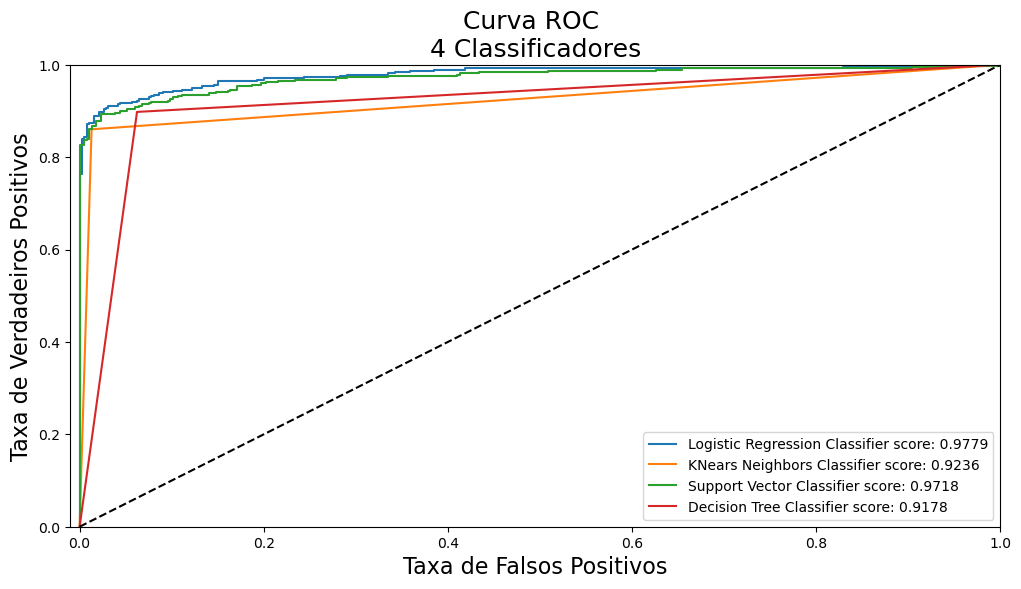

In [29]:
#Plot da curva ROC do modelo.

# Falso Positivo versus positivo real de todos os 4 classificadores
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr,
                             svc_tpr, tree_fpr, tree_tpr):
    # Cria a figura
    plt.figure(figsize=(12, 6))
    # Título
    plt.title('Curva ROC \n4 Classificadores', fontsize=18)
    # ROC AUC scores
    plt.plot(log_fpr,
             log_tpr,
             label='Logistic Regression Classifier score: {:.4f}'.format(
                 roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr,
             knear_tpr,
             label='KNears Neighbors Classifier score: {:.4f}'.format(
                 roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr,
             svc_tpr,
             label='Support Vector Classifier score: {:.4f}'.format(
                 roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr,
             tree_tpr,
             label='Decision Tree Classifier score: {:.4f}'.format(
                 roc_auc_score(y_train, tree_pred)))
    # Linha central
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])

    # Legenda do eixo X
    plt.xlabel('Taxa de Falsos Positivos', fontsize=16)

    # Legenda do eixo Y
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=16)

    plt.legend()


graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr,
                         svc_tpr, tree_fpr, tree_tpr)
plt.show()

In [30]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print('Train: ', train_index, 'Test:', test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[
        train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[
        train_index], undersample_y.iloc[test_index]

# Transformar em array
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

# Listas para armazenar os scores
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementação da técnica "NearMiss", apenas para ver a distribuição
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values,
                                                 undersample_y.values)
print('Distribuição NearMiss: ', Counter(y_nearmiss))

# Validação cruzada da maneira correta
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(
        NearMiss(sampling_strategy='majority'), log_reg)
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train],
                                                 undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(
        undersample_Xtrain[test])

    undersample_accuracy.append(
        undersample_pipeline.score(original_Xtrain[test],
                                   original_ytrain[test]))
    undersample_precision.append(
        precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(
        recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(
        f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(
        roc_auc_score(original_ytrain[test], undersample_prediction))

Train:  [ 56958  56959  56960 ... 284804 284805 284806] Test: [    0     1     2 ... 57479 58141 58272]
Train:  [     0      1      2 ... 284804 284805 284806] Test: [ 56958  56959  56960 ... 113934 113935 113936]
Train:  [     0      1      2 ... 284804 284805 284806] Test: [103933 104244 104367 ... 170900 170901 170902]
Train:  [     0      1      2 ... 284804 284805 284806] Test: [161693 163033 163270 ... 227861 227862 227863]
Train:  [     0      1      2 ... 227861 227862 227863] Test: [219129 219960 220516 ... 284804 284805 284806]
Distribuição NearMiss:  Counter({0: 492, 1: 492})


In [31]:
def plot_learning_curve(estimator1,
                        estimator2,
                        estimator3,
                        estimator4,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5)):

    # Cria a figura com 4 subplots
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,
                                               2,
                                               figsize=(20, 14),
                                               sharey=True)

    # Define os limites do eixo y
    if ylim is not None:
        plt.ylim(*ylim)

        # Primeiro "estimator"

        # Calcula a curva de aprendizado
        train_sizes, train_scores, test_scores = learning_curve(
            estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        # Média do treinamento
        train_scores_mean = np.mean(train_scores, axis=1)
        # Desvio-padrão do treinamento
        train_scores_std = np.std(train_scores, axis=1)
        # Média do teste
        test_scores_mean = np.mean(test_scores, axis=1)
        # Desvio-padrão do teste
        test_scores_std = np.std(test_scores, axis=1)
        # Preenche os eixos
        ax1.fill_between(train_sizes,
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha=0.1,
                         color="#ff9124")
        ax1.fill_between(train_sizes,
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std,
                         alpha=0.1,
                         color="#2492ff")
        # Insere nos eixos os scores de treino
        ax1.plot(train_sizes,
                 train_scores_mean,
                 'o-',
                 color="#ff9124",
                 label="Score de treino")
        # Insere nos eixos os scores da validação cruzada
        ax1.plot(train_sizes,
                 test_scores_mean,
                 'o-',
                 color="#2492ff",
                 label="Score da validação cruzada")
        # Título
        ax1.set_title("Logistic Regression", fontsize=14)
        # Legenda do eixo X
        ax1.set_xlabel('Training size (m)')
        # Legenda do eixo y
        ax1.set_ylabel('Score')
        # Desenha uma grande nos eixos
        ax1.grid(True)
        # Insere a legenda na melhor localização (onde não sobreponha as linhas desenhadas nos eixos)
        ax1.legend(loc="best")

        # Segundo "estimator"
        train_sizes, train_scores, test_scores = learning_curve(
            estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax2.fill_between(train_sizes,
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha=0.1,
                         color="#ff9124")
        ax2.fill_between(train_sizes,
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std,
                         alpha=0.1,
                         color="#2492ff")
        ax2.plot(train_sizes,
                 train_scores_mean,
                 'o-',
                 color="#ff9124",
                 label="Score de treino")
        ax2.plot(train_sizes,
                 test_scores_mean,
                 'o-',
                 color="#2492ff",
                 label="Cross-validation score")
        ax2.set_title("Knears Neighbors", fontsize=14)
        ax2.set_xlabel('Training size (m)')
        ax2.set_ylabel('Score')
        ax2.grid(True)
        ax2.legend(loc="best")

        # Terceiro "estimator"
        train_sizes, train_scores, test_scores = learning_curve(
            estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax3.fill_between(train_sizes,
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha=0.1,
                         color="#ff9124")
        ax3.fill_between(train_sizes,
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std,
                         alpha=0.1,
                         color="#2492ff")
        ax3.plot(train_sizes,
                 train_scores_mean,
                 'o-',
                 color="#ff9124",
                 label="Score de treino")
        ax3.plot(train_sizes,
                 test_scores_mean,
                 'o-',
                 color="#2492ff",
                 label="Cross-validation score")
        ax3.set_title("Support Vector Classifier", fontsize=14)
        ax3.set_xlabel('Training size (m)')
        ax3.set_ylabel('Score')
        ax3.grid(True)
        ax3.legend(loc="best")

        # Quarto "estimator"
        train_sizes, train_scores, test_scores = learning_curve(
            estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax4.fill_between(train_sizes,
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha=0.1,
                         color="#ff9124")
        ax4.fill_between(train_sizes,
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std,
                         alpha=0.1,
                         color="#2492ff")
        ax4.plot(train_sizes,
                 train_scores_mean,
                 'o-',
                 color="#ff9124",
                 label="Score de treino")
        ax4.plot(train_sizes,
                 test_scores_mean,
                 'o-',
                 color="#2492ff",
                 label="Cross-validation score")
        ax4.set_title("Decision Tree Classifier", fontsize=14)
        ax4.set_xlabel('Training size (m)')
        ax4.set_ylabel('Score')
        ax4.grid(True)
        ax4.legend(loc="best")

        # Retorna a figura
        return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\sann_\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

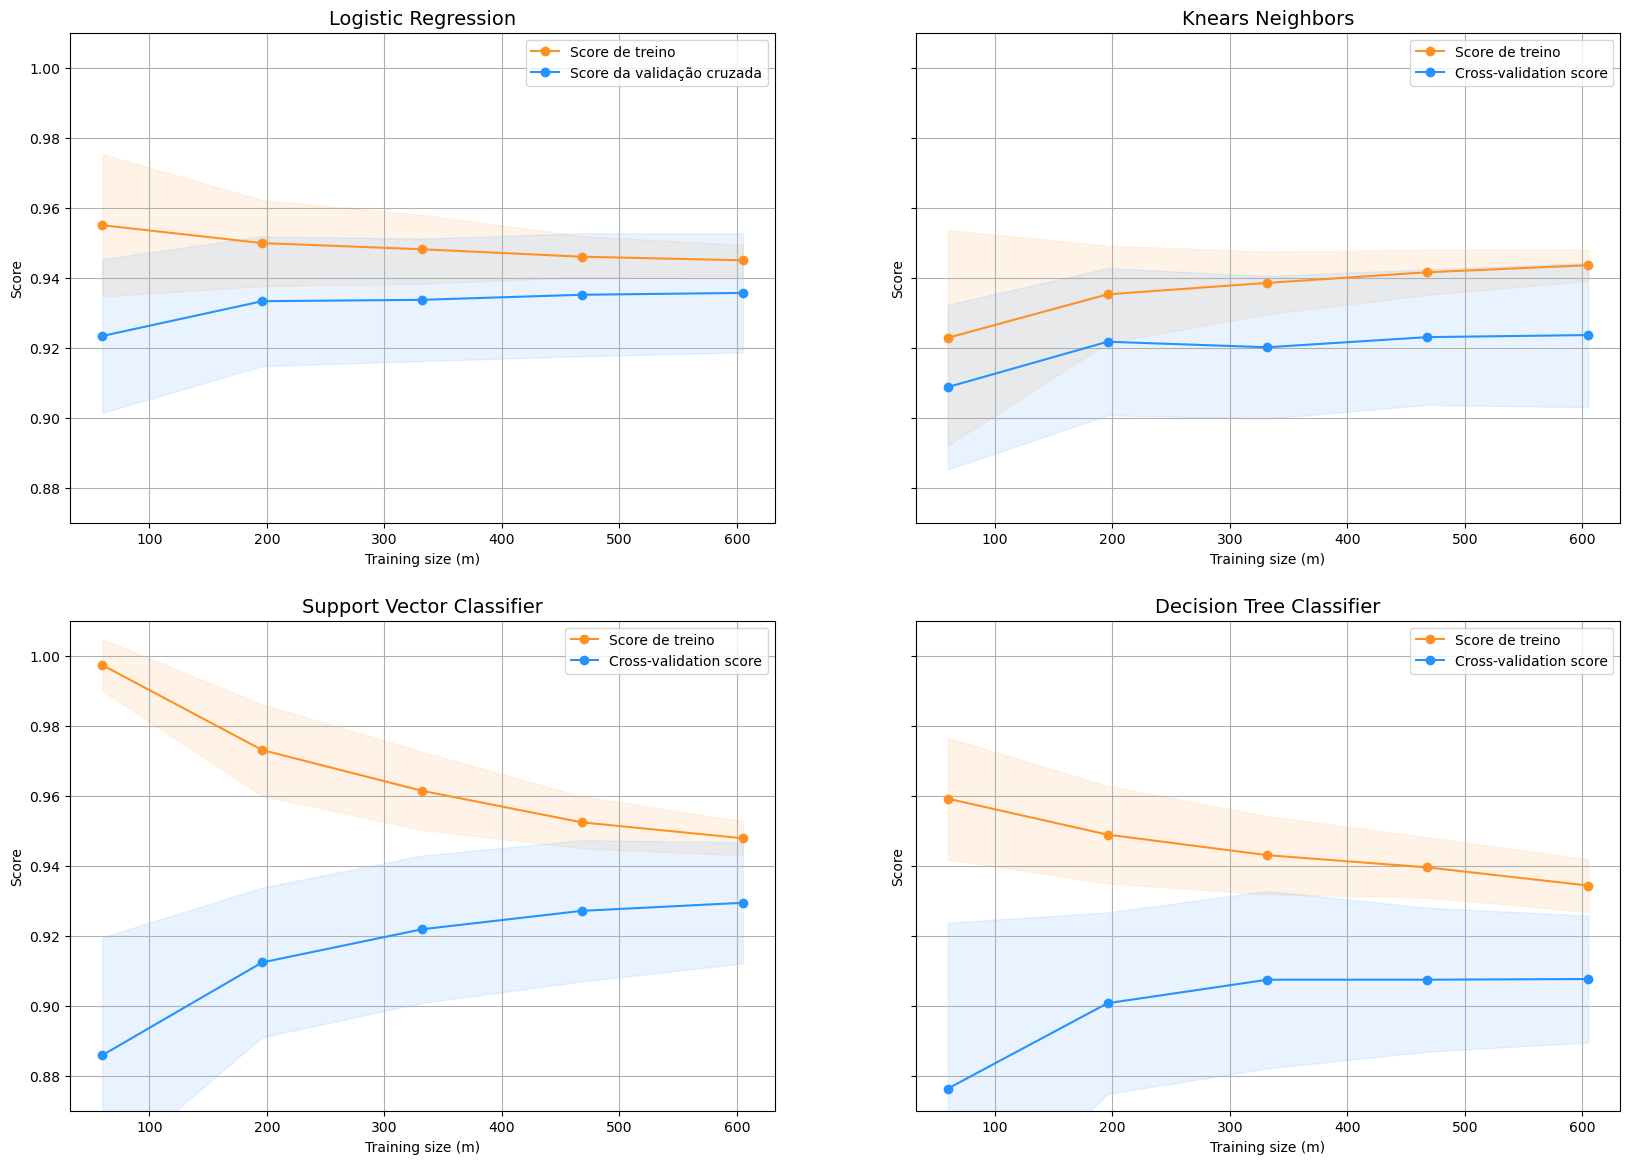

In [32]:
#Plot das curvas de aprendizagem dos modelos
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg,
                    knears_neighbors,
                    svc,
                    tree_clf,
                    X_train,
                    y_train, (0.87, 1.01),
                    cv=cv,
                    n_jobs=-1)

#### Novamente a regressão logistica tem uma performance melhor, vamos analisar esse modelo de perto.

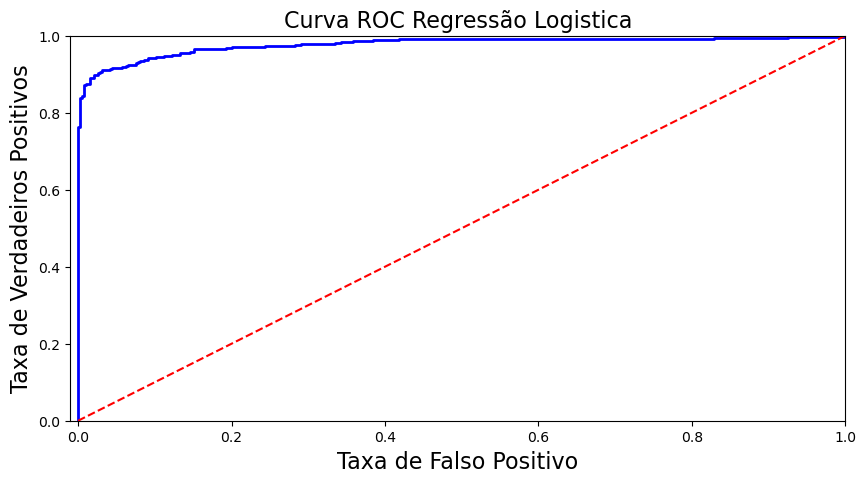

In [33]:
def log_roc_curve(log_fpr, log_tpr):
    # Cria a figura
    plt.figure(figsize=(10, 5))
    # Título
    plt.title('Curva ROC Regressão Logistica', fontsize=16)

    # FPR e TPR na cor azul
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    # Linha central na cor vermelha
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Taxa de Falso Positivo', fontsize=16)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=16)
    plt.axis([-0.01, 1, 0, 1])


log_roc_curve(log_fpr, log_tpr)
plt.show()

In [34]:
precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

# Predições
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))

print('---' * 45)

# Como deveria ser
print('Como deveria ser:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))

Overfitting: 

Recall Score: 0.91
Precision Score: 0.83
F1 Score: 0.87
Accuracy Score: 0.86
---------------------------------------------------------------------------------------------------------------------------------------
Como deveria ser:

Accuracy Score: 0.84
Precision Score: 0.00
Recall Score: 0.14
F1 Score: 0.00


Média da precisão -recall score: 0.08


Text(0.5, 1.0, 'Undersampling Precision-Recall curve: \nAverage Precision-Recall score = 0.08')

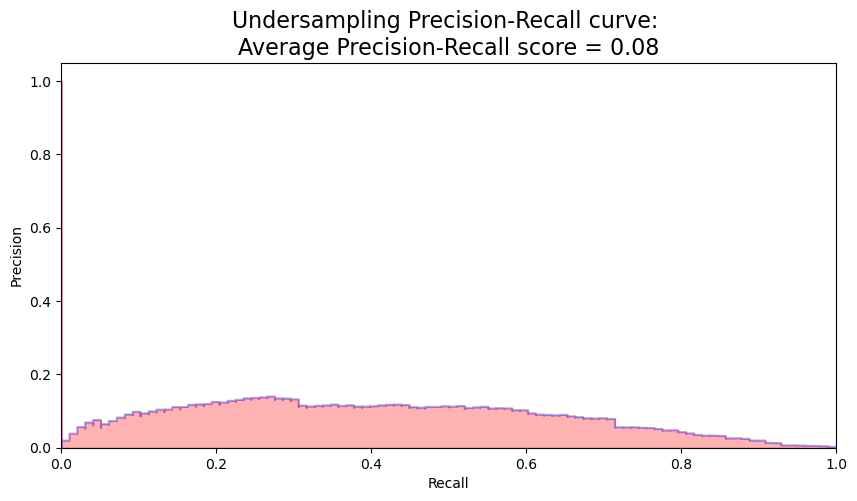

In [44]:
# Média de precision-recall
undersample_y_score = log_reg.decision_function(original_Xtest)
undersample_average_precision = average_precision_score(
    original_ytest, undersample_y_score)

print('Média da precisão -recall score: {0:0.2f}'.format(
    undersample_average_precision))

fig = plt.figure(figsize=(10, 5))

precision, recall, _ = precision_recall_curve(original_ytest,
                                              undersample_y_score)

plt.step(recall, precision, color='b', alpha=0.3, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Undersampling Precision-Recall curve: \nAverage Precision-Recall score = {0:0.2f}'
    .format(undersample_average_precision),
    fontsize=16)

O classificador com melhor desempenho foi a regressão logística, no entanto, identificamos que estamos sofrendo com overfitting. Para solucionar esse problema, uma abordagem alternativa é utilizar uma metodologia de amostragem diferente.

Nesse caso, podemos explorar técnicas de amostragem como SMOTE (Synthetic Minority Over-sampling Technique) ou ADASYN (Adaptive Synthetic Sampling) para lidar com o desequilíbrio de classes em nosso conjunto de dados. Essas técnicas sinteticamente geram exemplos da classe minoritária, o que pode ajudar a melhorar o desempenho do modelo na detecção de transações fraudulentas.

A metodologia escolhida foi o SMOTE, pois ela nos permite lidar com o desequilíbrio de classes sem perder informações significativas, ao contrário do undersampling.

Com essa abordagem, esperamos reduzir o overfitting e melhorar o desempenho do modelo na detecção de fraudes, aproveitando ao máximo as informações disponíveis em nosso conjunto de dados.

In [37]:
print('Tamanho do X (treino): {} | Tamanho do y (treino): {}'.format(
    len(original_Xtrain), len(original_ytrain)))
print('Tamanho do X (teste): {} | Tamanho do y (teste): {}'.format(
    len(original_Xtest), len(original_ytest)))

# Lista para armazenar os scores
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Parâmetros da Logistic Regression
log_reg_params = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Randomized SearchCV
rand_log_reg = RandomizedSearchCV(LogisticRegression(),
                                  log_reg_params,
                                  n_iter=4)

# Implementação do SMOTE
# Cross-validation da maneira correta
for train, test in sss.split(original_Xtrain, original_ytrain):
    # Pipeline
    pipeline = imbalanced_make_pipeline(
        SMOTE(sampling_strategy='minority'),
        rand_log_reg)  # SMOTE durante a validação cruzada
    # Treinamento do modelo
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    # Melhores parâmetros
    best_est = rand_log_reg.best_estimator_
    # Predições
    prediction = best_est.predict(original_Xtrain[test])

    # Armazena os "scores" nas listas criadas anteriormente
    accuracy_lst.append(
        pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

# Exibe os "scores"
print('---' * 40)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Tamanho do X (treino): 227846 | Tamanho do y (treino): 227846
Tamanho do X (teste): 56961 | Tamanho do y (teste): 56961
------------------------------------------------------------------------------------------------------------------------

accuracy: 0.97069090358325
precision: 0.06564449634332573
recall: 0.9112301200908796
f1: 0.12129432446051927
---------------------------------------------------------------------------------------------------------------------------------------


In [38]:
labels = ['Não fraudulenta', 'fraudulenta']

# Predição com SMOTE
smote_prediction = best_est.predict(original_Xtest)
# Printa a "classification report"
print(
    classification_report(original_ytest,
                          smote_prediction,
                          target_names=labels))

                 precision    recall  f1-score   support

Não fraudulenta       1.00      0.99      0.99     56863
    fraudulenta       0.11      0.86      0.20        98

       accuracy                           0.99     56961
      macro avg       0.56      0.92      0.60     56961
   weighted avg       1.00      0.99      0.99     56961



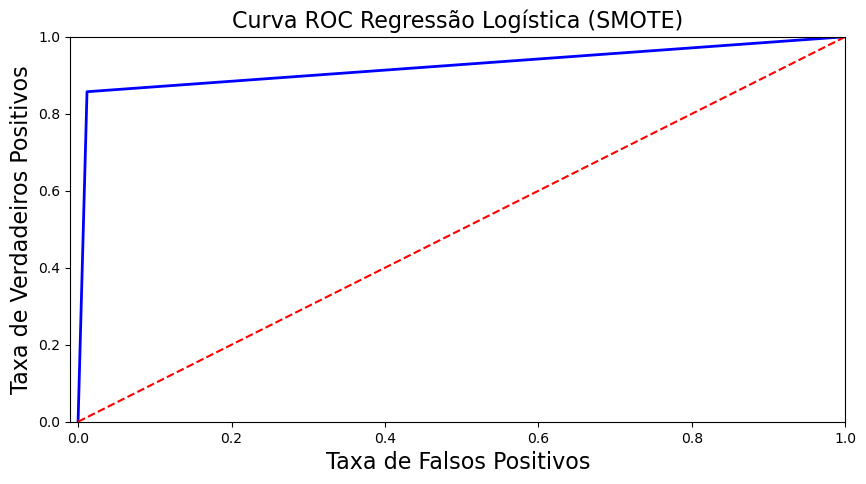

In [43]:
# Calcular FPR e TPR
log_fpr, log_tpr, _ = roc_curve(original_ytest, smote_prediction)


def log_roc_curve(log_fpr, log_tpr):
    # Cria a figura
    plt.figure(figsize=(10, 5))
    # Título
    plt.title('Curva ROC Regressão Logística (SMOTE)', fontsize=16)

    # Plot da curva ROC
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)

    # Linha diagonal
    plt.plot([0, 1], [0, 1], 'r--')

    # Legenda dos eixos
    plt.xlabel('Taxa de Falsos Positivos', fontsize=16)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=16)

    # Limites dos eixos
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1])

    # Exibição do gráfico
    plt.show()


log_roc_curve(log_fpr, log_tpr)

In [48]:
y_score = best_est.decision_function(original_Xtest)

In [49]:
average_precision = average_precision_score(original_ytest, y_score)

print('Média da precisão no oversampling-recall score: {0:0.2f}'.format(
      average_precision))

Média da precisão no oversampling-recall score: 0.75


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.75')

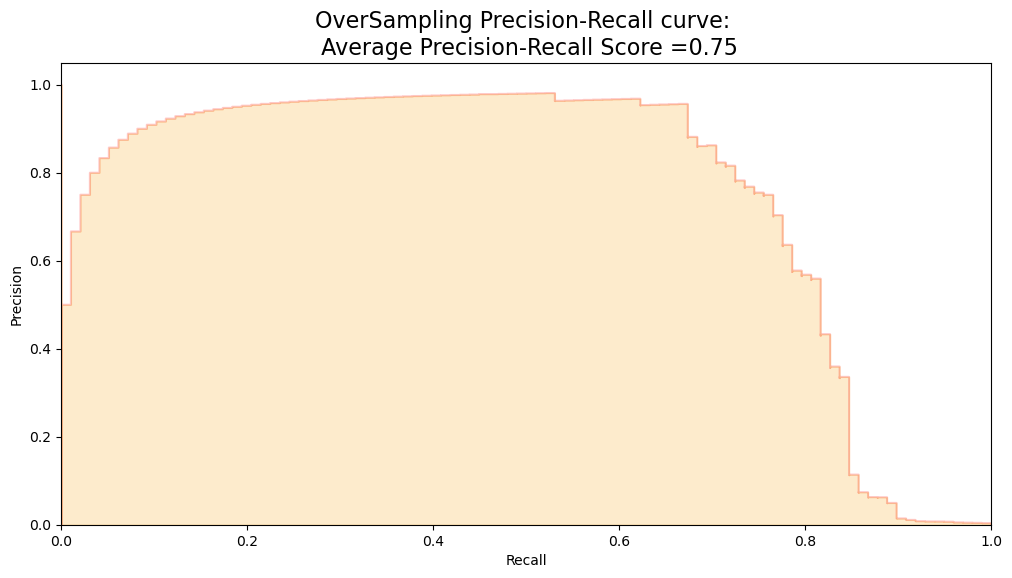

In [50]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

# Implementação na base de teste.

Vamos analisar nossos modelos na base de teste, utilizando uma matrix de confusão.

A confusion matrix (matriz de confusão) consiste em:

True Negatives (quadrado superior esquerdo): número de classificações corretas da classe 0 (transação não fraudulenta)
False Negatives (quadrado superior direito): número de classificações incorretas da classe 0 (transação não fraudulenta)
False Positives (quadrado inferior esquerdo): número de classificações incorretas da classe 1 (transação fraudulenta)
True Positives (quadrado inferior direito): número de classificações corretas da classe 1 (transação fraudulenta).

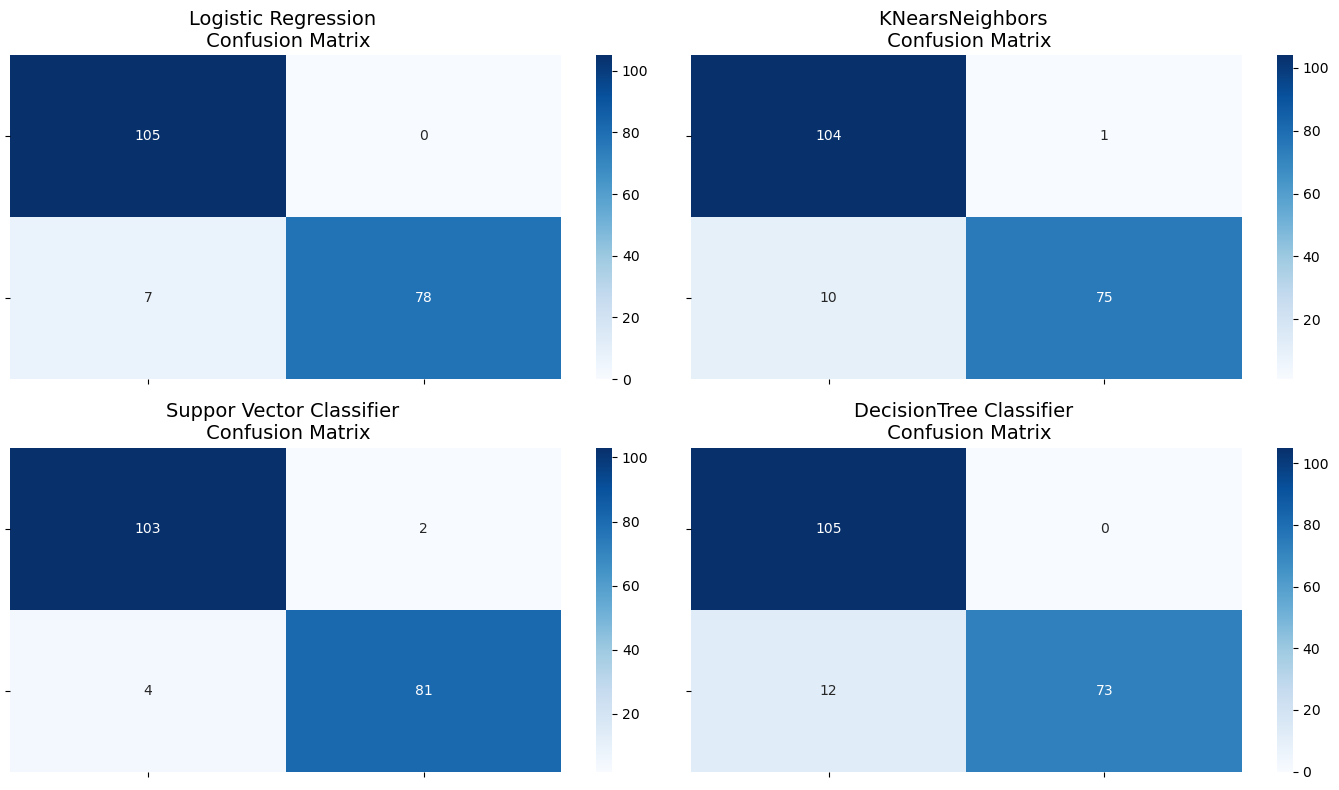

In [39]:
# Logistic Regression treinado com SMOTE
y_pred_log_reg = best_est.predict(X_test)

# Outros modelos com undersampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

# Matriz de confusão de todos os modelos
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

# Cria a figura e os axes
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# Exibe a matriz de confusão do modelo Logistic Regression
sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.Blues, fmt='d')
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Exibe a matriz de confusão do modelo Knears Neighbors
sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.Blues, fmt='d')
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Exibe a matriz de confusão do modelo SVC
sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.Blues, fmt='d')
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Exibe a matriz de confusão do modelo Decision Tree
sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.Blues, fmt='d')
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.tight_layout()
plt.show()

In [40]:
# classification_reports de todos os modelos

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('---' * 40)

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('---' * 40)

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('---' * 40)

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       105
           1       1.00      0.92      0.96        85

    accuracy                           0.96       190
   macro avg       0.97      0.96      0.96       190
weighted avg       0.97      0.96      0.96       190

------------------------------------------------------------------------------------------------------------------------
KNears Neighbors:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       105
           1       0.99      0.88      0.93        85

    accuracy                           0.94       190
   macro avg       0.95      0.94      0.94       190
weighted avg       0.95      0.94      0.94       190

------------------------------------------------------------------------------------------------------------------------
Support Vector Classifier:
              precision    recall  f1-

In [41]:
#Comparando o score da regressão logistica com undersampling e SMOTE.

# Logistic Regression com "undersampling"
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression com SMOTE
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

# Dicionário com os scores das duas técnicas (undersampling e oversampling)
d = {
    'Técnica': ['Random undersampling', 'Oversampling (SMOTE)'],
    'Score': [undersample_score, oversample_score]
}

# Cria um dataframe com o dicionário
final_df = pd.DataFrame(data=d)

# Armazena o "Score" em outra variável
score = final_df['Score']
# Remove a coluna "Score"
final_df.drop('Score', axis=1, inplace=True)
# Insere os dados armazenados anteriormente na segunda coluna
final_df.insert(1, 'Score', score)

final_df

,Técnica,Score
0,Random undersampling,0.894737
1,Oversampling (SMOTE),0.988132


# Conclusão.

Tão importante quanto detectar transações fraudulentas é assegurar que as transações legítimas dos clientes reais não sejam afetadas, evitando assim inconvenientes para os clientes e preservando a reputação do banco diante deles.

É importante lembrar que em conjuntos de dados desbalanceados, a acurácia não é uma métrica recomendada para avaliar o desempenho do modelo. Em vez disso, é mais indicado avaliar a Curva ROC.

O modelo de regressão logística foi escolhido com base no desempenho superior demonstrado pela Curva ROC durante o treinamento e validação do modelo. Isso motivou a análise mais detalhada desse modelo.

A técnica de oversampling (SMOTE) obteve resultados significativamente melhores em comparação com a técnica de undersampling aleatório. Isso pode ser atribuído ao fato de que o undersampling removeu várias amostras de dados não fraudulentos para igualar o número de exemplos entre as duas classes, resultando em perda de informações úteis para o modelo. Por outro lado, o SMOTE não removeu essas informações úteis, mas criou pontos sintéticos de dados fraudulentos, preservando assim as informações úteis no conjunto de dados.